In [34]:
import pandas as pd
import re

# Initialize a list to hold the complete lines (each representing a full list of skills)
complete_lines = []

# Initialize a variable to hold the current list being processed
current_list = ''

# Read the file and concatenate lines to form complete skill lists
with open('/home/eduardo/Documents/Persona3/AutoTelos/telos_1_attempt/predictionsOrignal.log', 'r') as f:
    for line in f:
        stripped_line = line.strip()

        # Skip lines containing 'optional skills found' or 'mandatory set found'
        if 'optional skills found' in stripped_line or 'mandatory set found' in stripped_line:
            continue

        if 'INFO:root:' in stripped_line:
            if current_list:
                complete_lines.append(current_list)
                current_list = ''
            current_list = stripped_line  # Start a new list
        else:
            current_list += ' ' + stripped_line  # Continuation of the current list

        if current_list.endswith(']'):
            complete_lines.append(current_list)
            current_list = ''

# Initialize a list to hold the parsed skills data
skills_data = []

# Process each complete line (full skill list) to extract skills
for line in complete_lines:
    skill_list_str = line.replace("INFO:root:", "").strip()[1:-1]

    # Regex pattern to include sequences within single or double quotes, or non-quoted words
    skills = re.findall(r"'([^']*)'|\"([^\"]*)\"|(\S+)", skill_list_str)

    # Flatten the tuples and filter out empty strings
    flattened_skills = [item for sublist in skills for item in sublist if item]

    skills_data.append(flattened_skills)

# Create a DataFrame with each skill in its own column
skills_df = pd.DataFrame(skills_data, columns=[f'Skill_{i+1}' for i in range(8)])

# Display the DataFrame to verify the results
print(skills_df.shape)
print(skills_df.head())


(41795, 8)
       Skill_1     Skill_2        Skill_3       Skill_4        Skill_5  \
0  Akasha Arts  Wind Boost   Poison Arrow      Mahamaon  Auto-Tarukaja   
1   Wind Boost  Evade Wind       Growth 3  High Counter   Morning Star   
2  Mind Charge  God's Hand     Wind Boost    Megidolaon       Mahamaon   
3     Megidola   Apt Pupil  Absorb Pierce      Growth 3   Stagnant Air   
4     Growth 2  Wind Boost     Evade Wind        Garula       Mahamaon   

        Skill_6        Skill_7        Skill_8  
0   Auto-Mataru   Spell Master   1hSwd Master  
1      Wind Amp  Tempest Slash  Auto-Sukukaja  
2      Growth 3   1hSwd Master   Invigorate 3  
3  High Counter     God's Hand     Evade Wind  
4  Ghastly Wail   Stagnant Air       Wind Amp  


In [35]:
# Iterate over the rows and check for repeated values
repeated_values = skills_df.apply(lambda row: row.nunique() < len(row), axis=1)

# Print the rows with repeated values
print(skills_df[repeated_values])

Empty DataFrame
Columns: [Skill_1, Skill_2, Skill_3, Skill_4, Skill_5, Skill_6, Skill_7, Skill_8]
Index: []


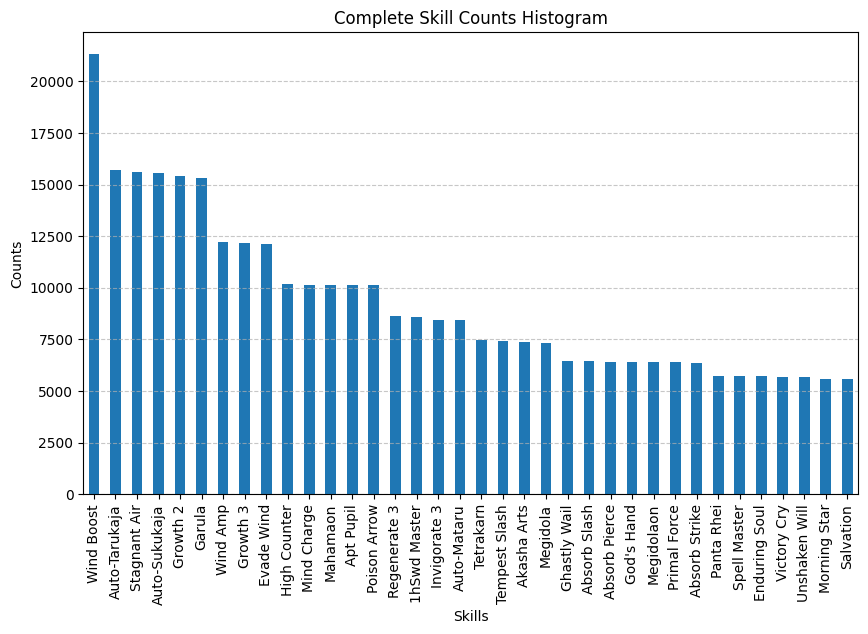

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming skills_df is already defined and loaded as per your previous code

# Flatten the DataFrame to get a list of all skills
all_skills = skills_df.values.flatten()

# Convert the list of all skills into a Series
skills_series = pd.Series(all_skills)

# Count the occurrences of each unique skill
skill_counts = skills_series.value_counts()

# Plotting the histogram
plt.figure(figsize=(10, 6))
skill_counts.plot(kind='bar')
plt.title('Complete Skill Counts Histogram')
plt.xlabel('Skills')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

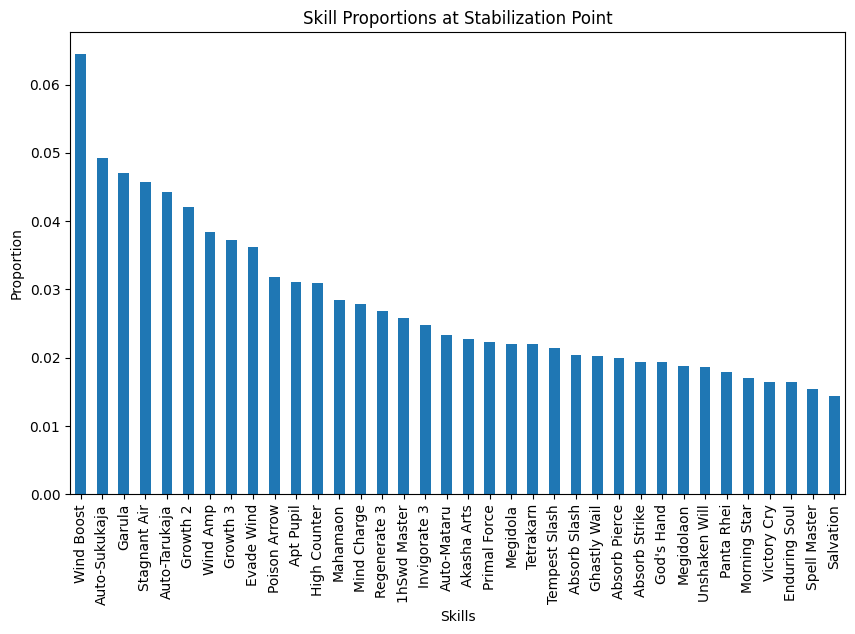

Stabilization Point: 7950


In [37]:
import pandas as pd
import numpy as np

def analyze_stabilization(df, step=100, threshold=0.01):
    """
    Analyze the stabilization of skill proportions in the DataFrame.

    :param df: DataFrame with skill occurrences.
    :param step: Number of rows to incrementally add for each subset analysis.
    :param threshold: Proportion change threshold to determine stabilization.
    :return: Stabilization point row index.
    """
    # Flatten the DataFrame to get a list of all skills
    all_skills = df.values.flatten()
    
    # Initialize variables
    last_proportions = None
    stabilization_point = None

    # Incrementally analyze the DataFrame
    for end in range(step, len(all_skills) + step, step):
        subset_skills = all_skills[:end]
        counts = pd.Series(subset_skills).value_counts()
        proportions = counts / counts.sum()
        
        # Skip the first iteration since there's no previous data to compare
        if last_proportions is not None:
            # Calculate the maximum proportion change for any skill
            proportion_changes = np.abs(proportions - last_proportions).fillna(0)
            max_change = proportion_changes.max()

            # Check if the maximum change is below the threshold
            if max_change < threshold:
                stabilization_point = end - step  # Use the previous end point as the stabilization point
                break
        
        last_proportions = proportions

    # Plotting the final proportions for visualization
    proportions.plot(kind='bar', figsize=(10, 6))
    plt.title('Skill Proportions at Stabilization Point')
    plt.xlabel('Skills')
    plt.ylabel('Proportion')
    plt.xticks(rotation=90)
    plt.show()

    return stabilization_point

# Flatten the DataFrame to create a single list of skills
skills_list = skills_df.values.flatten()

# Call the function to analyze stabilization
stabilization_point = analyze_stabilization(skills_df, step=10, threshold=0.0001)
print(f'Stabilization Point: {stabilization_point}')

In [38]:
import pandas as pd


df = pd.read_csv("/home/eduardo/Documents/Persona3/AutoTelos/skills_list/skills.csv")


skill_type_dict = df.set_index('skill')['type'].to_dict()

skill_rank_dict = df.set_index('skill')['rank'].to_dict()

# given a skill name return the skill type
def get_skill_type(skill_name):
    return skill_type_dict[skill_name]

def get_skill_rank(skill_name):
    return skill_rank_dict[skill_name]

# load '/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/inheritance.csv' into a dataframe
inheritance_df = pd.read_csv('/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/inheritance.csv')
# load '/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/personas_inheritance.csv' into a dataframe
persona_inheritance_df = pd.read_csv('/home/eduardo/Documents/Persona3/AutoTelos/inheritance_calculator/personas_inheritance.csv')

def get_persona_inheritance_type(persona_name):
    return persona_inheritance_df.loc[persona_inheritance_df['Persona'] == persona_name, 'Type'].iloc[0]



# Convert the DataFrame to a dictionary where each key is an inheritance type
# and its value is another dictionary of skill types and their probabilities.
inheritance_dict = inheritance_df.set_index('Inheritance Type').T.to_dict('dict')



# given a skill type return the skill inheritance probability for a given persona type
def get_inheritance_probability(skill_type, persona_inheritance_type):
    # Access the nested dictionary directly for the value
    # Check if the persona_inheritance_type exists to avoid KeyErrors
    if persona_inheritance_type in inheritance_dict:
        # Return the probability value for the given skill_type and persona_inheritance_type
        return inheritance_dict[persona_inheritance_type].get(skill_type, 0)  # Returns 0 if skill_type is not found

In [39]:
skill_counts_list = list(skill_counts.to_dict().keys())

ranks = []

dict_skill_to_rank = {}

for s in skill_counts_list:
    print(s, get_inheritance_probability(get_skill_type(s), get_persona_inheritance_type('orpheus telos')), get_skill_rank(s))
    ranks.append(get_skill_rank(s))
    dict_skill_to_rank[s] = get_skill_rank(s)

ranks = list(set(ranks))

print(ranks)

print(dict_skill_to_rank)




Wind Boost 1.0 2
Auto-Tarukaja 1.0 3
Stagnant Air 1.0 3
Auto-Sukukaja 1.0 3
Growth 2 1.0 3
Garula 1.0 3
Wind Amp 1.0 4
Growth 3 1.0 4
Evade Wind 1.0 4
High Counter 1.0 5
Mind Charge 1.0 5
Mahamaon 1.0 5
Apt Pupil 1.0 3
Poison Arrow 1.0 5
Regenerate 3 1.0 6
1hSwd Master 1.0 6
Invigorate 3 1.0 6
Auto-Mataru 1.0 6
Tetrakarn 1.0 7
Tempest Slash 1.0 7
Akasha Arts 1.0 7
Megidola 1.0 7
Ghastly Wail 1.0 8
Absorb Slash 1.0 8
Absorb Pierce 1.0 8
God's Hand 1.0 8
Megidolaon 1.0 8
Primal Force 1.0 8
Absorb Strike 1.0 8
Panta Rhei 1.0 9
Spell Master 1.0 9
Enduring Soul 1.0 9
Victory Cry 1.0 9
Unshaken Will 1.0 9
Morning Star 1.0 9
Salvation 1.0 9
[2, 3, 4, 5, 6, 7, 8, 9]
{'Wind Boost': 2, 'Auto-Tarukaja': 3, 'Stagnant Air': 3, 'Auto-Sukukaja': 3, 'Growth 2': 3, 'Garula': 3, 'Wind Amp': 4, 'Growth 3': 4, 'Evade Wind': 4, 'High Counter': 5, 'Mind Charge': 5, 'Mahamaon': 5, 'Apt Pupil': 3, 'Poison Arrow': 5, 'Regenerate 3': 6, '1hSwd Master': 6, 'Invigorate 3': 6, 'Auto-Mataru': 6, 'Tetrakarn': 7, 'Te

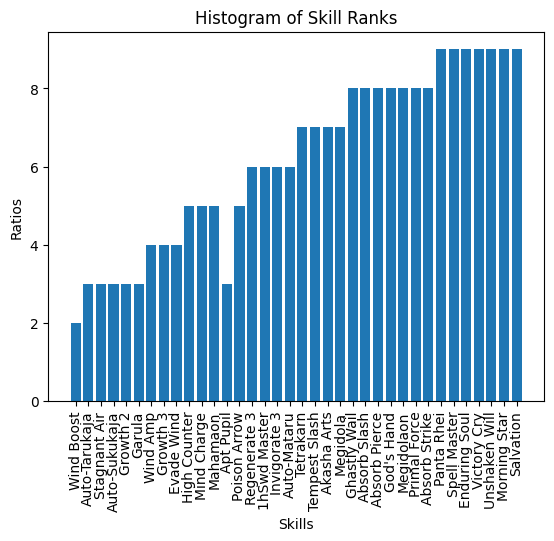

In [40]:
# Create lists of keys and values
skills = list(dict_skill_to_rank.keys())
ranks = list(dict_skill_to_rank.values())

# Create the histogram
plt.bar(skills, ranks)

# Add labels and title
plt.xlabel('Skills')
plt.ylabel('Ratios')
plt.title('Histogram of Skill Ranks')
plt.xticks(rotation=90)

# Show the plot
plt.show()